In [1]:
#CT image reconstruct through the FBP algorithm
#Written by Ren-Qi Pan
import math
import os
from pydicom import dcmread
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from numba import njit

In [2]:
_pth = r'F:\EPID Images\sphere\854320165'
# _pth = r'F:\EPID Images\2024-05-04 17-12-18-MV Dosimetry-6x_Patient 1_Arc CW\854320170'
_files = os.listdir(_pth)

In [3]:
dcm = dcmread(os.path.join(_pth, _files[0]))
shape = dcm.Rows, dcm.Columns

In [4]:
g_angle = []
_images = np.zeros((len(_files),shape[0], shape[0]), dtype=np.uint16)
prev = np.zeros((shape[0], shape[0]), dtype=np.uint16)
curr = np.zeros((shape[0], shape[0]), dtype=np.uint16)
_raw_datas = []
for idx, _fname in enumerate(tqdm(_files)):
    raw = dcmread(os.path.join(_pth, _fname))
    curr = raw.pixel_array
    
    _m = curr - prev
    
    if np.max(_m) > 10000:
        _images[idx, :, :] = _images[idx-1, :, :]
        g_angle.append(g_angle[idx-1])
    else:
        _images[idx, :, :] = curr - prev
        prev = curr
        g_angle.append(raw.GantryAngle)
        
    prev = curr


100%|██████████| 412/412 [00:04<00:00, 87.82it/s] 


In [5]:
g_angle = np.array(g_angle)
sorted_inx = np.argsort(g_angle)

sorted_images = np.zeros((len(_files),shape[0], shape[0]), dtype=np.uint16)

for idx, val in enumerate(tqdm(sorted_inx)):
    sorted_images[idx, :, :] = _images[val, :, :]

100%|██████████| 412/412 [00:01<00:00, 406.57it/s]


In [6]:
g_angle2 = g_angle[sorted_inx]
_images = []

In [7]:
#define the filter function: Ram-Lak (R-L) filter and the Shepp-Logan(S-L) filter
#N:number of detector cells
#d: step width of detector cells
PI=math.pi

def filter_SL(N,d):
    fh_SL=np.zeros(N)
    for k1 in range(0,N,1):
        fh_SL[k1]=-2.0/(PI*PI*d*d*(4*(k1-N/2.0)**2-1))
    return fh_SL

def nearestPowerOf2(N):
    # Calculate log2 of N
    a = int(math.log2(N))
    if 2**a == N:
        return N
    return 2**(a + 1)

## Initializing parameters and filters

In [12]:
SID = dcm.RTImageSID
SAD = dcm.RadiationMachineSAD


Ncolumns = sorted_images.shape[2]
Nimage=sorted_images.shape[0] #size of image
beta=g_angle2 #rotate(view) angles
SOD=SAD#source to origin distance, in unit mm
SDD=SID #source to center of detector, in unit mm
width=0.172 #size of detector cell, in unit mm
delta_dd=width*SOD/SDD #interval of the virtual detector cell
Nfft=nearestPowerOf2(2*Ncolumns-1) #number of points for FFT
fh_RL=filter_SL(Nfft,delta_dd)  #get the filter kernel function

## Fun weighted projection

In [13]:
projection_beta = sorted_images[0]
Nrows,Ncolumns=projection_beta.shape
dd_column=delta_dd*np.arange(-Ncolumns/2+0.5,(Ncolumns/2+1)-0.5,1.0)#coordinate of detector cell in horizontal 
dd_row=delta_dd*np.arange(-Nrows/2+0.5,(Nrows/2+1)-0.5,1.0)#coordinate of detector cell in vertical
dd_row2D,dd_column2D=np.meshgrid(dd_row,dd_column,indexing='ij')
weighted_projection=projection_beta*SOD/np.sqrt(SOD*SOD+np.power(dd_row2D,2.0)+np.power(dd_column2D,2.0))

## Applying filter

In [34]:
Nrows,Ncolumns=weighted_projection.shape
Nfft=nearestPowerOf2(2*Ncolumns-1)
filtered_projection=np.zeros((Nrows,Ncolumns))
for row in range(Nrows):
    projection_row=weighted_projection[row,:]
    zeros_pad=np.zeros(Nfft-Ncolumns)
    projection_row=np.concatenate((projection_row,zeros_pad))
    convoluted_time=np.convolve(projection_row,fh_RL/2.0,mode='same')
    convoluted_time=convoluted_time[:Ncolumns]
    filtered_projection[row,:]=convoluted_time

In [33]:
Nrows,Ncolumns=filtered_projection.shape
MX, MZ=Nimage,int(Nimage*Nrows/Ncolumns)
#roi[0], roi[1]: the min and max of x-axis and y-axis
#roi[2],roi[3]: the min and max of z-axis



roi=delta_dd*np.array([-Ncolumns/2.0+0.5,Ncolumns/2.0-0.5,-Nrows/2.0+0.5,Nrows/2.0-0.5])
hx=(roi[1]-roi[0])/(MX-1) #interval of x-axis and y-axis
xrange=roi[0]+hx*np.arange(0,MX) #coordinate vector of x-axis and y-axis 
hy=(roi[3]-roi[2])/(MZ-1) #interval of z-axis
yrange=roi[2]+hy*np.arange(0,MZ) #coordinate vector of z-axis 
XX,YY,ZZ=np.meshgrid(xrange,xrange,yrange,indexing='ij')
temp_rec=np.zeros((MX,MX,MZ)) #store back projection contribution
U=(SOD+XX*np.sin(beta_m)-YY*np.cos(beta_m))/SOD
a=(XX*np.cos(beta_m)+YY*np.sin(beta_m))/U
xx=np.int32(np.floor(a/delta_dd)) #beam numbering,strart from -Ncolumns/2
u1=a/delta_dd-xx  #the decimal part of a
b=ZZ/U
yy=np.int32(np.floor(b/delta_dd)) #beam numbering,strart from -Nrows/2
u2=b/delta_dd-yy #the decimal part of b
xx=xx+int(Ncolumns/2) #numbering from 0
yy=yy+int(Nrows/2) #numbering from 0

mask=np.where((xx >=0) & (xx< Ncolumns-1) & (yy >=0) & (yy<Nrows-1))
xx=xx[mask]
yy=yy[mask]
u1=u1[mask]
u2=u2[mask]
print(mask)
temp=(1-u1)*(1-u2)*filtered_projection[yy,xx]+(1-u1)*u2*filtered_projection[yy+1,xx]+\
            (1-u2)*u1*filtered_projection[yy,xx+1]+u1*u2*filtered_projection[yy+1,xx+1]
temp_rec[mask]=temp_rec[mask]+temp/(np.power(U[mask],2))*2*PI/beta_num

-247.23693117556147

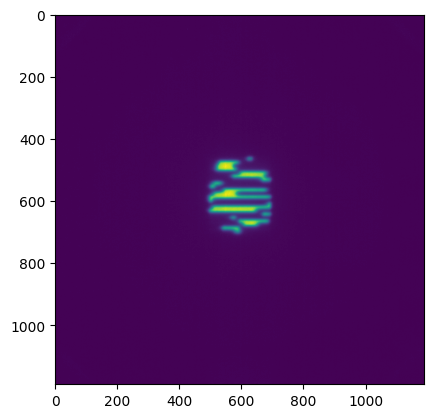

In [15]:
plt.imshow(weighted_projection)

In [8]:
# @njit(nopython=True, fastmath=True)
def Fun_Weigth_Projection(projection_beta,SOD,delta_dd):
    Nrows,Ncolumns=projection_beta.shape
    dd_column=delta_dd*np.arange(-Ncolumns/2+0.5,(Ncolumns/2+1)-0.5,1.0)#coordinate of detector cell in horizontal 
    dd_row=delta_dd*np.arange(-Nrows/2+0.5,(Nrows/2+1)-0.5,1.0)#coordinate of detector cell in vertical
    dd_row2D,dd_column2D=np.meshgrid(dd_row,dd_column,indexing='ij')
    weighted_projection=projection_beta*SOD/np.sqrt(SOD*SOD+np.power(dd_row2D,2.0)+np.power(dd_column2D,2.0))
    return weighted_projection

# @njit(nopython=True, parallel=True,fastmath=True)
def Fun_Filter_Projection(weighted_projection,fh_RL):
    Nrows,Ncolumns=weighted_projection.shape
    Nfft=nearestPowerOf2(2*Ncolumns-1)
    filtered_projection=np.zeros((Nrows,Ncolumns))
    for row in range(Nrows):
        projection_row=weighted_projection[row,:]
        zeros_pad=np.zeros(Nfft-Ncolumns)
        projection_row=np.concatenate((projection_row,zeros_pad))
        convoluted_time=np.convolve(projection_row,fh_RL/2.0,mode='same')
        convoluted_time=convoluted_time[:Ncolumns]
        filtered_projection[row,:]=convoluted_time
    return filtered_projection

# @njit(fastmath=True)
def Fun_BackProjection(filtered_projection,SOD,beta_num,beta_m,delta_dd,Nimage):
    Nrows,Ncolumns=filtered_projection.shape
    MX, MZ=Nimage,int(Nimage*Nrows/Ncolumns)
    #roi[0], roi[1]: the min and max of x-axis and y-axis
    #roi[2],roi[3]: the min and max of z-axis
    
    roi=delta_dd*np.array([-Ncolumns/2.0+0.5,Ncolumns/2.0-0.5,-Nrows/2.0+0.5,Nrows/2.0-0.5])
    hx=(roi[1]-roi[0])/(MX-1) #interval of x-axis and y-axis
    xrange=roi[0]+hx*np.arange(0,MX) #coordinate vector of x-axis and y-axis 
    hy=(roi[3]-roi[2])/(MZ-1) #interval of z-axis
    yrange=roi[2]+hy*np.arange(0,MZ) #coordinate vector of z-axis 
    XX,YY,ZZ=np.meshgrid(xrange,xrange,yrange,indexing='ij')
    temp_rec=np.zeros((MX,MX,MZ)) #store back projection contribution
    U=(SOD+XX*np.sin(beta_m)-YY*np.cos(beta_m))/SOD
    a=(XX*np.cos(beta_m)+YY*np.sin(beta_m))/U
    xx=np.int32(np.floor(a/delta_dd)) #beam numbering,strart from -Ncolumns/2
    u1=a/delta_dd-xx  #the decimal part of a
    b=ZZ/U
    yy=np.int32(np.floor(b/delta_dd)) #beam numbering,strart from -Nrows/2
    u2=b/delta_dd-yy #the decimal part of b
    xx=xx+int(Ncolumns/2) #numbering from 0
    yy=yy+int(Nrows/2) #numbering from 0

    mask=np.where((xx >=0) & (xx< Ncolumns-1) & (yy >=0) & (yy<Nrows-1))
    xx=xx[mask]
    yy=yy[mask]
    u1=u1[mask]
    u2=u2[mask]
    print(mask)
    temp=(1-u1)*(1-u2)*filtered_projection[yy,xx]+(1-u1)*u2*filtered_projection[yy+1,xx]+\
                 (1-u2)*u1*filtered_projection[yy,xx+1]+u1*u2*filtered_projection[yy+1,xx+1]
    temp_rec[mask]=temp_rec[mask]+temp/(np.power(U[mask],2))*2*PI/beta_num
    print('backprojection, beta: ',round(beta_m*180/PI,1))
    return temp_rec


In [9]:
# @njit(nopython=True,fastmath=True)
def ConeBeam_FDK_Backprojection(projection,fh_RL,beta,SOD,Nimage,delta_dd):
    # projection: projection data in 3D, (angle,row, colums)
    # fh_RL: R-L filter function
    # beta: rotate angles in degrees
    # SOD: source to rotation center distance in mm unit
    # delta_dd: interval of the virtual detector cell
    Ncolumns=projection.shape[2]
    Nrows=projection.shape[1]
    rec_image=np.zeros((Nimage,Nimage,int(Nimage*Nrows/Ncolumns)))
    beta_num=len(beta) #number of angles
    beta=beta*PI/180.0 # view angle in radian
    for m in range(0, beta_num,1):
        projection_beta=projection[m,:,:] #projection matrix at the beta angle
        weighted_projection=Fun_Weigth_Projection(projection_beta,SOD,delta_dd)
        filtered_projection=Fun_Filter_Projection(weighted_projection,fh_RL)
        rec_image=rec_image+Fun_BackProjection(filtered_projection,SOD,beta_num,beta[m],delta_dd,Nimage)
        break
    return rec_image

c:\Users\Pintu\miniconda3\envs\gpy\Lib\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [11]:
plt.plot(weighted_projection)

NameError: name 'weighted_projection' is not defined

In [ ]:
Nimage=sorted_images.shape[0] #size of image
beta=g_angle2 #rotate(view) angles
SOD=SAD#source to origin distance, in unit mm
SDD=SID #source to center of detector, in unit mm
width=0.172 #size of detector cell, in unit mm
delta_dd=width*SOD/SDD #interval of the virtual detector cell
Nfft=nearestPowerOf2(2*Ncolumns-1) #number of points for FFT
fh_RL=filter_SL(Nfft,delta_dd)  #get the filter kernel function
#reconstruct the scanned object through the FBP algorithm
rec_image=ConeBeam_FDK_Backprojection(sorted_images,fh_RL,beta,SOD,Nimage,delta_dd)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'Fun_BackProjection':[0m [1m[1mCannot determine Numba type of <class 'function'>[0m
[1m
File "C:\Users\Pintu\AppData\Local\Temp\ipykernel_61520\1705567353.py", line 17:[0m
[1mdef ConeBeam_FDK_Backprojection(projection,fh_RL,beta,SOD,Nimage,delta_dd):
    <source elided>
        filtered_projection=Fun_Filter_Projection(weighted_projection,fh_RL)
[1m        rec_image=rec_image+Fun_BackProjection(filtered_projection,SOD,beta_num,beta[m],delta_dd,Nimage)
[0m        [1m^[0m[0m
[0m

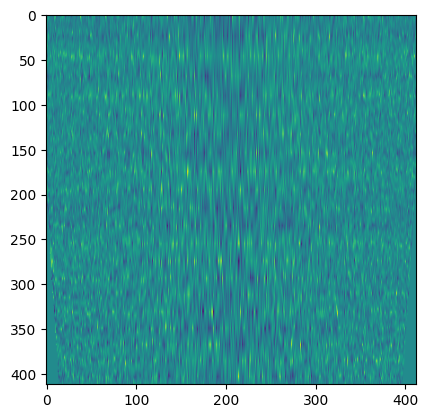

In [ ]:
plt.imshow(rec_image[140,:,:])

In [ ]:
Ncolumns

1190

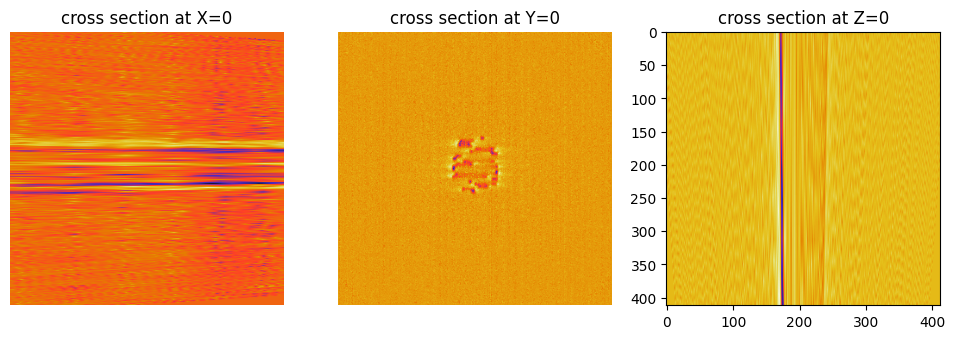

In [ ]:
NimageZ=Nimage*sorted_images.shape[0]/sorted_images.shape[0]
Z_c=int(NimageZ/2.0)
X_c=int(Nimage/2.0)
Y_c=int(Nimage/2.0)
figure, axis=plt.subplots(1, 3,figsize=(12,12))
axis[0].imshow(rec_image[X_c,:,:].T, cmap='CMRmap_r')
axis[0].set_title('cross section at X=0')
axis[0].axis('off')
axis[1].imshow(rec_image[:,Y_c,:].T, cmap='CMRmap_r')
axis[1].set_title('cross section at Y=0')
axis[1].axis('off')
axis[2].imshow(rec_image[:,:,Z_c].T, cmap='CMRmap_r')
axis[2].set_title('cross section at Z=0')
# axis[2].axis('off')
# plt.savefig(directory+"rec_image.pdf",format='pdf',dpi=250)
plt.show()

from mayavi import mlab
# Visualize with Mayavi
mlab.contour3d(rec_image, contours=10, opacity=0.3)
mlab.savefig(directory+'rec_image3D.png')
mlab.show()